Depth:   0%|          | 0/1 [00:00<?, ?it/s]

Structure search, depth 1:   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | Gate Combinations:   0%|          | 0/36 [00:00<?, ?it/s]

PROCESSING TASKS | Gate Combinations:   0%|          | 0/36 [00:00<?, ?it/s]

COLLECTING RESULTS | Gate Combinations:   0%|          | 0/36 [00:00<?, ?it/s]

QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | : 0it [00:00, ?it/s]

COLLECTING RESULTS | : 0it [00:00, ?it/s]

Data Information:
-----------------


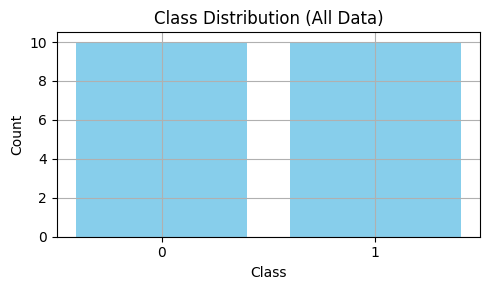

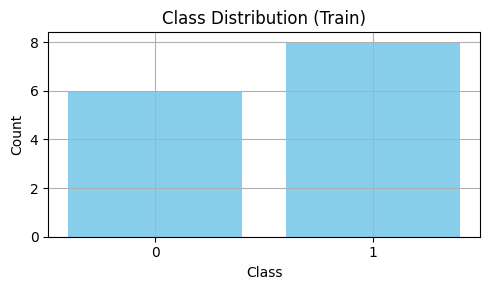

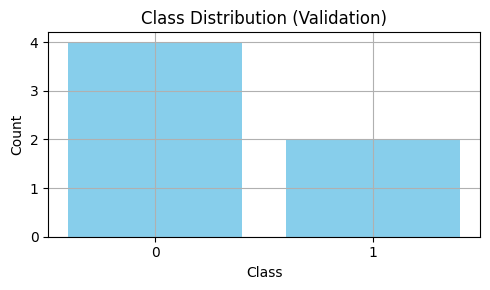

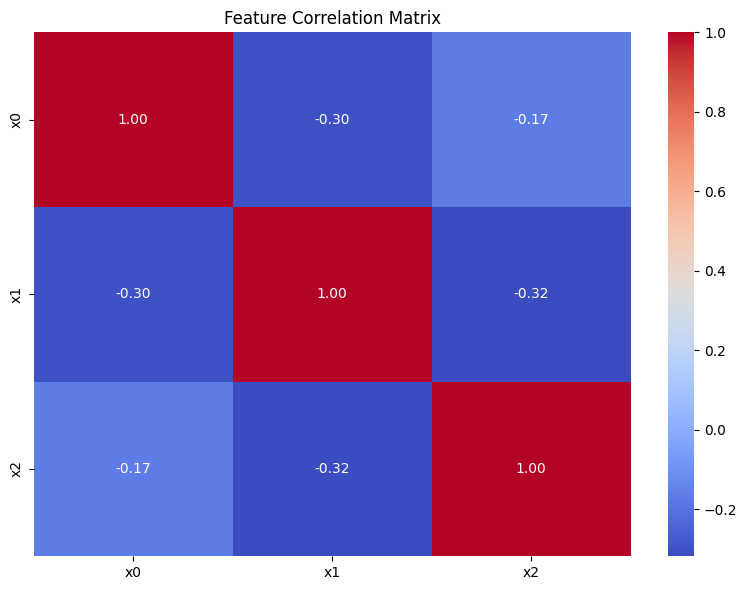

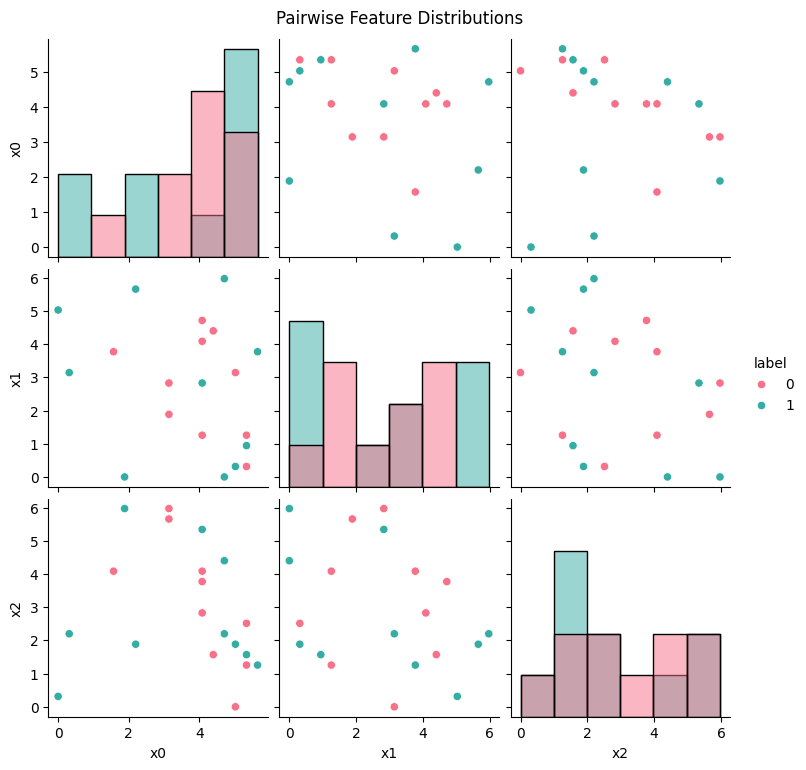

-----------------
Parameter Information:
K: 0
M: 0
N: 10
L Max: 1
Qubits: 3
Seed: 1376
-----------------
Best circuits:
-----------------


In [ ]:
#!/usr/bin/env python
import numpy as np
from typing import List
import pennylane as qml
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
from qiskit_machine_learning.datasets import ad_hoc_data
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm as tqdm
from skopt import gp_minimize
from skopt.space import Real
from sklearn.metrics import accuracy_score, f1_score, classification_report
import seaborn as sns
import pandas as pd
from collections import Counter
from qiskit_machine_learning.utils import algorithm_globals
from pqdm.processes import pqdm
# from tqdm.notebook import tqdm as tqdm_notebook
# pqdm.progress.tqdm = tqdm
K = 5  # Top circuits to keep per iteration
M = 5  # Number of circuits to optimize parameters from top K
N = 100  # Data size
L_MAX = 1  # Max circuit depth
QUBITS = 3  # Number of qubits
seed = 1376
algorithm_globals.random_seed = seed
%matplotlib inline
# matplotlib.use("TkAgg")
# %matplotlib inline  # Only works inside a Jupyter cell
projector = np.zeros((2 ** QUBITS, 2 ** QUBITS))
projector[0,0] = 1

def gate_combinations(qubits: int):
    if qubits == 0:
        yield []
    else:
        for combination in gate_combinations(qubits - 1):
            yield combination + [0]
            yield combination + [1]
            yield combination + [2]
            for offset in range(1, len(combination) + 1):
                if combination[-offset] == 0 and all(
                    combination[-offset + o] != o + 2 for o in range(1, offset + 1)
                ):
                    yield combination + [offset + 2]


def create_pennylane_circuit(instructions: List[List[int]]):
    dev = qml.device("default.qubit", wires=QUBITS)

    @qml.qnode(dev)
    def circuit(xparams=[], yparams=[]):
        for q in range(QUBITS):
            qml.Hadamard(wires=q)
            qml.RX(xparams[q], wires=q)

        idx = 0
        for layer in instructions:
            for qbit, op in enumerate(layer):
                if op == 0:
                    continue
                elif op == 1:
                    qml.Hadamard(wires=qbit)
                elif op == 2:
                    qml.RZ(yparams[idx], wires=qbit)
                    idx += 1
                elif op >= 3:
                    qml.CNOT(wires=[qbit, qbit - op + 2])
        return qml.state()

    return circuit


def build_kernel_fn(gate_layers, rz_params):
    dev = qml.device("default.qubit", wires=QUBITS)

    def apply_circuit(x):
        idx = 0
        for q in range(QUBITS):
            qml.Hadamard(wires=q)
            qml.RX(x[q], wires=q)
        for layer in gate_layers:
            for qbit, op in enumerate(layer):
                if op == 0:
                    continue
                elif op == 1:
                    qml.Hadamard(wires=qbit)
                elif op == 2:
                    qml.RZ(rz_params[idx], wires=qbit)
                    idx += 1
                elif op >= 3:
                    qml.CNOT(wires=[qbit, qbit - op + 2])

    @qml.qnode(dev)
    def kernel_qnode(x1, x2):
        apply_circuit(x1)
        qml.adjoint(apply_circuit)(x2)
        # return qml.probs(wires=0)
        # return qml.expval(qml.PauliZ(wires=range(QUBITS)))
        return qml.expval(qml.Hermitian(projector,wires=range(QUBITS)))

    def kernel_fn(X1, X2):
        K = np.zeros((len(X1), len(X2)))
        for i in range(len(X1)):
            for j in range(len(X2)):
                K[i, j] = kernel_qnode(X1[i], X2[j])
        return K

    return kernel_fn


def compute_information_criteria(y_true, y_prob, num_params):
    y_pred = (y_prob >= 0.5).astype(int)
    n = len(y_true)
    loglik = -log_loss(y_true, y_prob, normalize=False)
    aic = 2 * num_params - 2 * loglik
    bic = num_params * np.log(n) - 2 * loglik

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    report = classification_report(
        y_true, y_pred, output_dict=True, zero_division=0)
    class_accuracies = {
        f"class_{cls}": report[cls]["recall"] for cls in report if cls in ("0", "1")
    }

    return aic, bic, acc, class_accuracies, f1


# Load data
# np.random.seed(42)
X_train_raw, y_train_raw, X_test_raw, y_test_raw = ad_hoc_data(
    training_size=N // 2, test_size=N // 2, n=QUBITS, gap=0.3, one_hot=False
)

X = np.vstack([X_train_raw, X_test_raw])
y = np.hstack([y_train_raw, y_test_raw])
X, y = shuffle(X, y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42)

optimal_circuits = []


for depth in tqdm(range(1, L_MAX + 1), desc="Depth"):
    # print("phase 1")
    base_circuits = (
        [(c[0], c[1])
         for c in optimal_circuits] if optimal_circuits else [([], [])]
    )
    stage1_candidates = []
    # Stage 1: Structure search (fixed/random RZ)
    for base, base_rz in tqdm(base_circuits, desc=f"Structure search, depth {depth}"):

        def calculate_combo(combo):
            new_circ = base + [combo]
            num_rz = sum(layer.count(2) for layer in new_circ)
            # print(f"Trying circuit {new_circ} with {num_rz} RZs")
            new_rz_count = combo.count(2)
            new_rz = np.random.uniform(-np.pi, np.pi,
                                       size=new_rz_count).tolist()
            dummy_rz = base_rz + new_rz

            try:
                kernel_fn = build_kernel_fn(new_circ, dummy_rz)
                K_train = kernel_fn(X_train, X_train)
                model = SVC(kernel="precomputed", probability=True)
                model.fit(K_train, y_train)

                K_val = kernel_fn(X_val, X_train)
                y_prob = model.predict_proba(K_val)[:, 1]

                aic, bic, acc, class_accs, f1 = compute_information_criteria(
                    y_val, y_prob, num_rz
                )
                return (new_circ, dummy_rz, aic, bic, acc, class_accs, f1, model)
            except Exception as e:
                print(f"Structure error: {e}")
                return None

        result = pqdm(
            list(gate_combinations(QUBITS)),
            calculate_combo,
            n_jobs=12,
            desc="Gate Combinations",
        )
        for thing in result:
            if thing is not None:
                stage1_candidates.append(thing)

    # Pick top K by BIC
    stage1_candidates.sort(key=lambda x: x[3])
    # print("phase 2")
    # top_k = stage1_candidates[:K]
    param_circuits = [item for item in stage1_candidates if len(item[1]) > 0]
    unparam_circuits = [
        item for item in stage1_candidates if len(item[1]) == 0]
    # top_m = param_circuits[:M]
    # Stage 2: Parameter optimization on top M circuits
    stage2_optimized = []

    def parameter_optimization(values):
        circ, init_rz, aic, bic, acc, class_accs, f1, model1 = values
        num_rz = len(init_rz)
        if num_rz == 0:
            return (circ, [], aic1, bic1, model1)

        def objective(params):
            try:
                kernel_fn = build_kernel_fn(circ, params)
                K_train = kernel_fn(X_train, X_train)
                model = SVC(kernel="precomputed", probability=True)
                model.fit(K_train, y_train)
                K_val = kernel_fn(X_val, X_train)
                y_prob = model.predict_proba(K_val)[:, 1]
                _, bic = compute_information_criteria(y_val, y_prob, num_rz)
                return bic
            except Exception:
                return 1e6

        space = [Real(-np.pi, np.pi) for _ in range(num_rz)]
        result = gp_minimize(objective, space, n_calls=15, random_state=0)
        best_params = result.x

        try:
            kernel_fn = build_kernel_fn(circ, best_params)
            K_train = kernel_fn(X_train, X_train)
            model = SVC(kernel="precomputed", probability=True)
            model.fit(K_train, y_train)
            K_val = kernel_fn(X_val, X_train)
            y_prob = model.predict_proba(K_val)[:, 1]
            aic, bic, acc, class_accs, f1 = compute_information_criteria(
                y_val, y_prob, num_rz
            )
            return (circ, best_params, aic, bic, acc, class_accs, f1, model)

        except Exception as e:
            print(f"Final model error: {e}")
            return None

    stage2_optimized = [
        x
        for x in pqdm(param_circuits[:M], parameter_optimization, n_jobs=12)
        if x is not None
    ]

    # print("phase 3")

    # Add remaining K-M circuits (unoptimized) + optimized ones
    optimal_circuits = stage2_optimized + param_circuits[M:] + unparam_circuits
    optimal_circuits.sort(key=lambda x: x[3])  # sort by BIC
    optimal_circuits = optimal_circuits[:K]  # keep top K


df = pd.DataFrame(X, columns=[f"x{i}" for i in range(X.shape[1])])
df["label"] = y
print("Data Information:")
print("-----------------")


# --- Class Distribution ---
def plot_class_distribution(labels, title):
    counter = Counter(labels)
    plt.figure(figsize=(5, 3))
    plt.bar(counter.keys(), counter.values(), color="skyblue")
    plt.xticks([0, 1])
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()


plot_class_distribution(y, "Class Distribution (All Data)")
plot_class_distribution(y_train, "Class Distribution (Train)")
plot_class_distribution(y_val, "Class Distribution (Validation)")

# --- Correlation Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop(columns=["label"]).corr(),
            annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.tight_layout()

if X.shape[1] == 2:
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="Set1")
    plt.title("2D Scatter Plot by Class")
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.tight_layout()

# --- Pairplot (if ≤ 4D) ---
if X.shape[1] <= 4:
    sns.pairplot(df, hue="label", palette="husl", diag_kind="hist")
    plt.suptitle("Pairwise Feature Distributions", y=1.02)
plt.show()

print("-----------------")
print("Parameter Information:")
print(f"K: {K}")
print(f"M: {M}")
print(f"N: {N}")
print(f"L Max: {L_MAX}")
print(f"Qubits: {QUBITS}")
print(f"Seed: {seed}")
print("-----------------")
print("Best circuits:")
print("-----------------")

# Final results
for i, (circ, rz, aic, bic, acc, class_accs, f1, model) in enumerate(optimal_circuits):
    print(f"\nCircuit {i + 1}:")
    print(f"AIC = {aic:.2f}, BIC = {bic:.2f}")
    print(f"Accuracy = {acc:.3f}, F1 Score = {f1:.3f}")
    print(f"Class-wise Accuracy: {class_accs}")
    print(f"RZ Params: {rz}")
    dummy_x = [0.0] * QUBITS
    qml.drawer.draw_mpl(create_pennylane_circuit(circ))(dummy_x, rz)
    plt.title(f"Circuit {i + 1}")
    plt.show()
